# Урок 6. Градиентный бустинг

In [2]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

In [3]:
from sklearn.datasets import load_diabetes

In [4]:
X, y = load_diabetes(return_X_y=True)

In [5]:
X.shape

(442, 10)

In [6]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [7]:
def gb_predict(X, trees_list, coef_list, eta):
    return np.array([sum([eta*coef*alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])


В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функицию.

In [8]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [9]:
def deriv(y, z):
    return 2*(y - z)

Реализуем функцию обучения градиентного бустинга.

In [10]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            pred = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, deriv(y_train, pred))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

In [11]:
%%time
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

Wall time: 2.74 s


In [12]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [13]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 2866.870058269294
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тестовой выборке: 10209.690755862699


Построим графики зависимости ошибки на обучающей и тестовой выборках от числа итераций.

In [14]:
import matplotlib.pyplot as plt

In [15]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

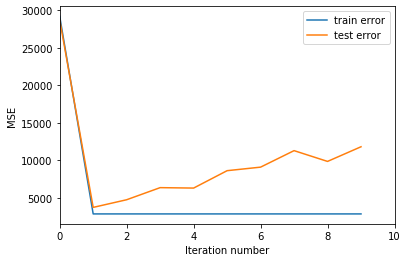

In [16]:
get_error_plot(n_trees, train_errors, test_errors)

Такой результат не является удовлетворительным

Увеличим число деревьев.

In [100]:
%%time
n_trees = 100
coefs = [1] * n_trees

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

Wall time: 4min 33s


In [101]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 100 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 2687.2255516050795
Ошибка алгоритма из 100 деревьев глубиной 3     с шагом 1 на тестовой выборке: 10413.339111789559


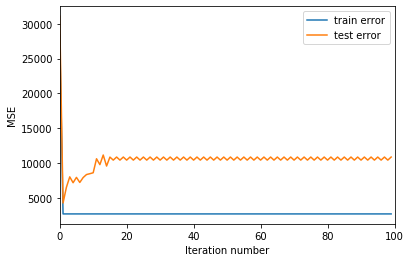

In [102]:
get_error_plot(n_trees, train_errors, test_errors)

Теперь попробуем уменьшить шаг.

In [103]:
%%time
eta = 0.1
n_trees = 50
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

Wall time: 1min 6s


In [104]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 883.3191776663208
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 4035.0985331086586


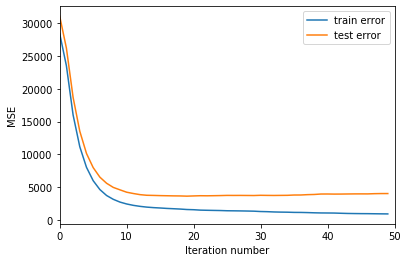

In [105]:
get_error_plot(n_trees, train_errors, test_errors)

Видим, что качество обучения улучшается.

Уменьшим шаг до 0.01.

In [123]:
%%time
eta = 0.01
n_trees = 50
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

KeyboardInterrupt: 

In [107]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.01 на тренировочной выборке: 5898.251881317915
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.01 на тестовой выборке: 7872.31667351414


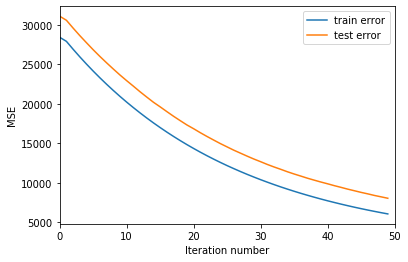

In [108]:
get_error_plot(n_trees, train_errors, test_errors)

При таком размере шага алгоритм сходится, но ему для достижения удовлетворительных показателей требуется большее количество итераций.

Вернемся к шагу 0.1 и попробуем увеличить глубину деревьев

In [109]:
%%time
eta = 0.1
max_depth = 100
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

Wall time: 1min 5s


In [110]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 100     с шагом 0.1 на тренировочной выборке: 7.331536121135515e-06
Ошибка алгоритма из 50 деревьев глубиной 100     с шагом 0.1 на тестовой выборке: 6882.703482409071


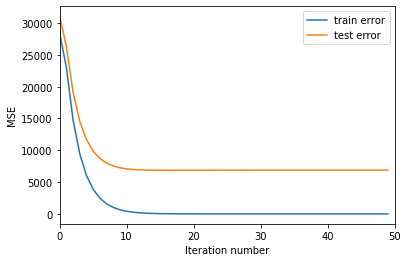

In [111]:
get_error_plot(n_trees, train_errors, test_errors)

## AdaBoost

In [112]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer

In [113]:
X, y = load_breast_cancer(return_X_y=True)

Разделим выборку на обучающую и тестовую

In [114]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Реализуем функцию подсчета ошибки

In [115]:
def get_error(pred, y):
    return sum(pred != y) / len(y)

И сам алгоритм

In [116]:
def adaboost(X, y, N):

    # Размер выборки
    n_objects = len(X)

    # Запишем количество классов в переменную
    n_classes = len(np.unique((y)))

    # Начальные веса деревьев
    w = np.ones(n_objects) / n_objects

    # Деревья с весами будем записывать в список
    models = []

    for n in range(N):
        # Зададим дерево и обучим его
        clf = DecisionTreeClassifier(max_depth=1)
        clf.fit(X, y, sample_weight=w)

        predictions = clf.predict(X)
        e = get_error(predictions, y)
        # отбросим дерево, если его ошибка больше 0.5
        # Запишем условие в общем виде (применимо к небинарным классификаторам)
        if e >= 1 - 1/n_classes: 
            break

        # Вычислим вес для дерева
        alpha = 0.5 * np.log((1 - e) / e)

        # Найдем индексы правильно классифицированных элементов
        match = predictions == y

        # Увеличим веса для неправильно классифицированных элементов
        w[~match] *= np.exp(alpha)

        # Нормализуем веса
        w /= w.sum()

        # Добавим дерево с весом в список
        models.append((alpha, clf))
    
    return models

Обучим алгоритм из 50 деревьев

In [117]:
N = 100
models = adaboost(X_train, y_train, N)

Теперь осуществим предсказание

In [118]:
def predict(X, models):
    
    n_classes = 2
    n_objects = len(X)
    
    # вначале обозначим предсказание нулевым массивом
    y_pred = np.zeros((n_objects, n_classes))
    
    for alpha, clf in models:
        prediction = clf.predict(X)
        # Для каждого предсказания будем прибавлять alpha к
        # элементу с индексом предсказанного класса
        y_pred[range(n_objects), prediction] += alpha
    
    # выберем индексы с максимальными суммарными весами -
    # получим предсказанные алгоритмом классы
    y_pred = np.argmax(y_pred, axis=1)
    
    return y_pred

In [119]:
print(f'Точность алгоритма на обучающей выборке: {(1 - get_error(predict(X_train, models), y_train)) * 100:.3f}')
print(f'Точность алгоритма на тестовой выборке: {(1 - get_error(predict(X_test, models), y_test)) * 100:.3f}')

Точность алгоритма на обучающей выборке: 98.826
Точность алгоритма на тестовой выборке: 95.105


Построим графики зависимости ошибки от количества базовых алгоритмов в ансамбле.

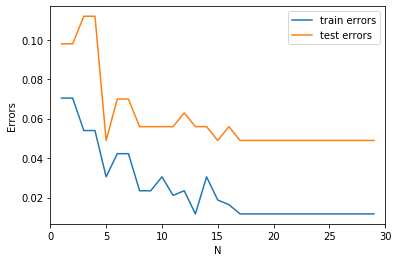

In [120]:
train_errors = []
test_errors = []

for n in range(1, 30):
    mods = adaboost(X_train, y_train, n)
    train_errors.append(get_error(predict(X_train, mods), y_train))
    test_errors.append(get_error(predict(X_test, mods), y_test))
    
x = list(range(1, 30))

plt.xlim(0, 30)
plt.plot(x, train_errors, label='train errors')
plt.plot(x, test_errors, label='test errors')
plt.xlabel('N')
plt.ylabel('Errors')
plt.legend(loc='upper right');

## Дополнительные материалы

1. [Лекция Радослава Нейчева на тему ансамблей](https://www.youtube.com/watch?v=md5krGNRrwU&list=PL4_hYwCyhAvasRqzz4w562ce0esEwS0Mt&index=8&t=10s)
2. [Интерактивная визуализация градиентного бустинга](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)

### Домашнее задание:  
1. Для реализованной модели (gb_fit) построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.  
2. Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

#### 1. Для реализованной модели (gb_fit) построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [35]:
#Деревья от 1 до 30
#Глубина от 1 до 50
all_trees = np.linspace(1,30, 30, dtype=int)
tree_depths = np.linspace(1,50, 50, dtype=int)

In [36]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    
    mse_train = mean_squared_error(y_train, train_prediction)

    print(f'Ошибка алгоритма из {n_tree} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mse_train}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)
    
    mse_test = mean_squared_error(y_test, test_prediction)

    print(f'Ошибка алгоритма из {n_tree} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mse_test}')
    return mse_train, mse_test
    

In [37]:
eta = 0.1
max_depth = 3
train_mse = []
test_mse = []
for n_tree in all_trees:
    coefs = [1] * n_tree
    trees, train_errors, test_errors = gb_fit(n_tree, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    trainmse, testmse = evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)
    train_mse.append(trainmse)
    test_mse.append(testmse)

        

Ошибка алгоритма из 1 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 24193.82014490801
Ошибка алгоритма из 1 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 23820.09526368946
Ошибка алгоритма из 2 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 16509.34575260841
Ошибка алгоритма из 2 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 16200.375011687001
Ошибка алгоритма из 3 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 11564.073855639797
Ошибка алгоритма из 3 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 11454.78161328372
Ошибка алгоритма из 4 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 8334.439161193586
Ошибка алгоритма из 4 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 8395.174609255087
Ошибка алгоритма из 5 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 6232.3849953338595
Ошибка алгоритма из 5 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 6360.029809273949
Ош

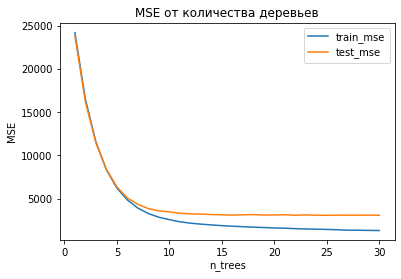

In [38]:
x = all_trees

plt.plot(x, train_mse, label='train_mse')
plt.plot(x, test_mse, label='test_mse')
plt.xlabel('n_trees')
plt.ylabel('MSE')
plt.title('MSE от количества деревьев')
plt.legend(loc='upper right');

Видим, что с увеличением количества деревьев ошибка постепенно уменьшается, но ошибка на тренировочной выборке постоянно уменьшается (на выбранном нами отрезке), а на тестовой - стремится к определённому ненулевому значению

In [39]:
eta = 0.1
n_tree = 10
train_mse = []
test_mse = []
for max_depth in tree_depths:
    coefs = [1] * n_tree
    trees, train_errors, test_errors = gb_fit(n_tree, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    trainmse, testmse = evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)
    train_mse.append(trainmse)
    test_mse.append(testmse)


Ошибка алгоритма из 10 деревьев глубиной 1     с шагом 0.1 на тренировочной выборке: 3599.1928156558333
Ошибка алгоритма из 10 деревьев глубиной 1     с шагом 0.1 на тестовой выборке: 3691.5923385659057
Ошибка алгоритма из 10 деревьев глубиной 2     с шагом 0.1 на тренировочной выборке: 3049.2598432541463
Ошибка алгоритма из 10 деревьев глубиной 2     с шагом 0.1 на тестовой выборке: 3423.189881628779
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 2570.6606538476813
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 3466.438328654011
Ошибка алгоритма из 10 деревьев глубиной 4     с шагом 0.1 на тренировочной выборке: 1926.7218224132164
Ошибка алгоритма из 10 деревьев глубиной 4     с шагом 0.1 на тестовой выборке: 3636.3168141280835
Ошибка алгоритма из 10 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 1379.7739921110242
Ошибка алгоритма из 10 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 3773.4

Ошибка алгоритма из 10 деревьев глубиной 42     с шагом 0.1 на тренировочной выборке: 426.0245790132392
Ошибка алгоритма из 10 деревьев глубиной 42     с шагом 0.1 на тестовой выборке: 6027.583754176041
Ошибка алгоритма из 10 деревьев глубиной 43     с шагом 0.1 на тренировочной выборке: 426.0245790132392
Ошибка алгоритма из 10 деревьев глубиной 43     с шагом 0.1 на тестовой выборке: 6027.583754176041
Ошибка алгоритма из 10 деревьев глубиной 44     с шагом 0.1 на тренировочной выборке: 426.0245790132392
Ошибка алгоритма из 10 деревьев глубиной 44     с шагом 0.1 на тестовой выборке: 6027.583754176041
Ошибка алгоритма из 10 деревьев глубиной 45     с шагом 0.1 на тренировочной выборке: 426.0245790132392
Ошибка алгоритма из 10 деревьев глубиной 45     с шагом 0.1 на тестовой выборке: 6027.583754176041
Ошибка алгоритма из 10 деревьев глубиной 46     с шагом 0.1 на тренировочной выборке: 426.0245790132392
Ошибка алгоритма из 10 деревьев глубиной 46     с шагом 0.1 на тестовой выборке: 602

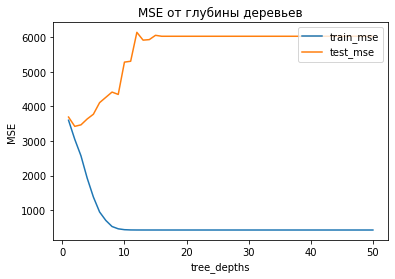

In [40]:
x = tree_depths

plt.plot(x, train_mse, label='train_mse')
plt.plot(x, test_mse, label='test_mse')
plt.xlabel('tree_depths')
plt.ylabel('MSE')
plt.title('MSE от глубины деревьев')
plt.legend(loc='upper right');

Видим, что буквально после 3 деревьев модель уходит в переобучение и там и остаётся

#### 2. Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [ ]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            pred = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, deriv(y_train, pred))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [46]:
def stohastic_gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, subsample_size=0.5):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        if len(trees) == 0:
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            selected_indexes = list(range(X_train.shape[0]))
            train_indexes = np.random.choice(selected_indexes, size=int(subsample_size*len(selected_indexes)))
            
            pred = gb_predict(X_train[train_indexes], trees, coefs, eta)
            
            tree.fit(X_train[train_indexes], deriv(y_train[train_indexes], pred))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [49]:
n_trees = 40
coefs = [1] * n_trees
max_depth = 3
eta = 0.1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
trees, s_train_errors, s_test_errors = stohastic_gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

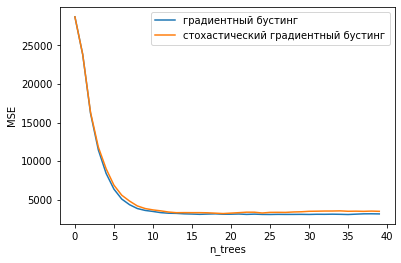

In [50]:
plt.plot(list(range(n_trees)), test_errors, label='градиентный бустинг')
plt.plot(list(range(n_trees)), s_test_errors, label='стохастический градиентный бустинг')
plt.xlabel('n_trees')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.show();